In [188]:
import pandas as pd
import numpy as np
import scipy.signal
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
from sklearn import  linear_model
from sklearn.preprocessing import  PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [189]:
def readDeathData(country):
    """
    Liest Daten ueber die Anzahl der Tote aus
    :param country: Land
    :return: ausgelesene Daten
    """
    death_data = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
    data = death_data[(death_data['Country/Region'] == country)].iloc[:,4:]
    return data.sum()

def readConfirmedData(country):
    """
    liest die Daten ueber die Anzahl der Infizierten ein
    :param country: Land
    :return: ausgelesene Daten
    """
    recover_data = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
    data = recover_data[(recover_data['Country/Region'] == country)].iloc[:,4:]
    return data.sum()

def readRecoveredData(country):
    """
    liest die Daten ueber die Anzahl der Genesenen ein
    :param country: Land
    :return: ausgelesene Daten
    """
    recover_data = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
    data = recover_data[(recover_data['Country/Region'] == country)].iloc[:,4:]
    return data.sum()

In [190]:
#Populationsstand verschiedener Laender
popu_dict = {'Germany':82927922, 'Italy':60482200}

def load_IR(name, N, t,T=None):
    """
    Laedt die Daten der Faelle, Genesenen und Toten
    :param name: Das zu betrachtende Land
    :param N: Gesamtpopulation
    :param t: Startzeitpunkt
    :param T: Endzeitpunkt (optional)
    :return: Aktive Infizierte, Genesen, Tote, gesamte Faelle
    """
    #T=163

    R = readRecoveredData(name)
    D = readDeathData(name)
    C = readConfirmedData(name)
    R = R.tolist()[t:T]
    D = D.tolist()[t:T]
    C = C.tolist()[t:T]
    R = np.array(R)
    D = np.array(D)
    C = np.array(C)
    I = C - R - D
    return I,R,D,C

def SSE(I_t, I):
    """
    Summe des quadratischen Fehlers
    :param I_t: modellierte Infizierte
    :param I: Infizierte aus Daten
    :return: Summe des quadratischen Fehlers
    """
    sse = (I_t[:len(I)] - I)**2
    return sse.sum()

def RungeKutta(beta, gamma, N, S_0, I_0, R_0, t):
    """
    Runge-Kutta-Verfahren zum loesen des SIR-Modells
    :param beta: Kontaktrate
    :param gamma: Genseungsrate
    :param N: Gesamtpopulation
    :param S_0: Anfangswert des Anfaelligen
    :param I_0: Anfangswert des Infizierten
    :param R_0: Anfangswert der Toten/Genesenen
    :param t: Startzeitpunkt
    :return: geloestes SIR-Modell ab t mit S_t, I_t, R_t
    """
    days = 200
    X = np.arange(t, days)
    I_t = np.zeros(days)
    S_t = np.zeros(days)
    R_t = np.zeros(days)
    I_t[0] = I_0
    S_t[0] = S_0
    R_t[0] = R_0
    h = 1
    for i in range(1, days):
        k11 = -beta * S_t[i-1] * I_t[i-1] / N
        k21 = beta * S_t[i-1] * I_t[i-1] / N - gamma * I_t[i-1]
        k31 = gamma * I_t[i-1]

        k12 = -beta * (S_t[i-1] + h / 2 * k11) * (I_t[i-1] + h / 2 * k21) / N
        k22 = beta * (S_t[i-1] + h / 2 * k11) * (I_t[i-1] + h / 2 * k21) / N - gamma * (I_t[i-1] + h / 2 * k21)
        k32 = gamma * (I_t[i-1] + h / 2 * k21)

        k13 = -beta * (S_t[i-1] + h / 2 * k12) * (I_t[i-1] + h / 2 * k22) / N
        k23 = beta * (S_t[i-1] + h / 2 * k12) * (I_t[i-1] + h / 2 * k22) / N - gamma * (I_t[i-1] + h / 2 * k22)
        k33 = gamma * (I_t[i-1] + h / 2 * k22)

        k14 = -beta * (S_t[i-1] + h * k13) * (I_t[i-1] + h * k23) / N
        k24 = beta * (S_t[i-1] + h * k13) * (I_t[i-1] + h * k23) / N - gamma * (I_t[i-1] + h * k23)
        k34 = gamma * (I_t[i-1] + h * k23)

        S_t[i] = S_t[i-1] + h / 6 * (k11 + 2 * k12 + 2 * k13 + k14)
        I_t[i] = I_t[i-1] + h / 6 * (k21 + 2 * k22 + 2 * k23 + k24)
        R_t[i] = R_t[i-1] + h / 6 * (k31 + 2 * k32 + 2 * k33 + k34)
    return S_t[t:],I_t[t:],R_t[t:]

def create_assist_date(datestart = None,dateend = None):
    """
    Erstellt eine Liste von Daten
    :param datestart: Startdatum
    :param dateend: Enddatum
    :return: Liste von Daten zwischen datestart und dateend
    """
    if datestart is None:
        datestart = '2016-01-01'
    if dateend is None:
        dateend = datetime.datetime.now().strftime('%Y-%m-%d')

    datestart=datetime.datetime.strptime(datestart,'%Y-%m-%d')
    dateend=datetime.datetime.strptime(dateend,'%Y-%m-%d')
    date_list = [datestart.strftime('%Y-%m-%d')]
    while datestart<dateend:
        datestart+=datetime.timedelta(days=+1)
        date_list.append(datestart.strftime('%Y-%m-%d'))
    return date_list

def predictPlot(I, I_t, t=None):
    """
    Plot von I und I_t
    :param I: gemessenen Infizierten
    :param I_t: modellierte oder vorhergesagt Infizierte
    :param t: Start ab wann vorhergesagt wird
    """
    #date_X = create_assist_date("2020-1-22", "2020-10-01")
    x_test  =pd.date_range(start='1/22/2020', end='10/1/2023', freq='D')
    X = np.arange(0, len(I_t))
    ax  = plt.figure(figsize=(14, 8))
    plt.grid(b=True, which='major', color='#666666', linestyle='-')
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    sns.lineplot(x_test[:len(I)], I, label = 'echte Daten')
    sns.set_style('whitegrid')
    if t is not None:
        sns.lineplot(x_test[0:t],I_t[0:t],label="Modelliert")
        sns.lineplot(x_test[t:len(I_t)], I_t[t:], label='Vorhersage')
    else:
        sns.lineplot(x_test[:len(I_t)],I_t,label="Modelliert")
    plt.xlabel('Zeit')
    plt.ylabel('Anzahl aktiver Infizierten')
    plt.title('SIR Modell')

def oneDayError(I,I_p):
    """
    Vorhersage Fehler
    :param I: gemessene Daten
    :param I_p: modellierte oder vorhergesagte Daten
    :return: Liste der Fehler
    """
    error = ((I_p[:len(I)] - I)/I)
    X = np.arange(0, len(error))
    x_test  =pd.date_range(start='1/22/2020', end='10/1/2023', freq='D')
    ax  = plt.figure(figsize=(13, 8))
    sns.set_style('darkgrid')
    sns.lineplot(x_test[:len(error)],error, label="Error")
    plt.xlabel('Date')
    plt.ylabel('Size of Error')
    plt.title('Prediction Error')
    plt.savefig('error.png')
    return error

def read_I_t(I,country, size):
    """
    Liest die bereits modellierten Werte von I_t ein
    :param I: gemessene I
    :param country: Land
    :param size: Groesse des Zeitfenster
    :return: Liste der modellierten I
    """
    I_t_list = []
    I_t_all = []
    I_t_p = list(I[0:size])

    for i in range(0, len(I)- size +1 ):
        if i == len(I) - size:
            j = len(I) - 1
        else:
            j = i + size - 1
        file_name = str(i) + '_'+str(j)+'_It.csv'
        a = pd.read_csv('data/'+country+'/'+str(size)+'/'+file_name,engine='python')
        I_t = list(a['I_t'])
        I_t_list.append(I_t)

        if i == len(I) - size:
            I_t_all = I_t_all + I_t
            I_t_p = I_t_p + I_t[size:]
        else:
            I_t_all = I_t_all + I_t[:1]
            I_t_p.append(I_t[size])
    return I_t_p,I_t_all


def read_opt(I,country, size):
    """
    liest die optimalen Parameter
    :param I: gemessene I
    :param country: Land
    :param size: Groesse des Zeitfenster
    :return: Liste von optimalen beta und gamma
    """
    beta_list = []
    gamma_list = []
    for i in range(0, len(I)- size+1):
        if i == len(I) - size:
            j = len(I) - 1
        else:
            j = i + size-1
        file_name = str(i) + '_'+str(j)+'_opt.csv'
        a = pd.read_csv('data/'+country+'/'+str(size)+'/'+file_name,engine='python')
        #opt = a.iloc[a['sse'].idxmin(),][1:3].tolist()
        opt = a.iloc[0,1:3].tolist()
        beta_list.append(opt[0])
        gamma_list.append(opt[1])
    beta_list = np.array(beta_list,dtype="float64")
    gamma_list = np.array(gamma_list,dtype="float64")
    return beta_list,gamma_list

In [191]:

minMSE = float('inf')
opt = 0

def paramPredict(datasets_X,datasets_Y):
    """
    Vorhersage mithilfer einer polynomialen Regression
    :param datasets_X: Ausgangsgroesse
    :param datasets_Y: Zielgroesse
    :return: Vorhersage von Y
    """
    #Mit degree kann der Grad des Polynoms fuer die Regression eingestellt werden
    poly_reg =PolynomialFeatures(degree=2)
    X_ploy =poly_reg.fit_transform(datasets_X)
    lin_reg_2=linear_model.LinearRegression()
    lin_reg_2.fit(X_ploy,datasets_Y)
    y_predict = lin_reg_2.predict(poly_reg.fit_transform(datasets_X))
    nextX = np.array(datasets_X[-1][0]+1).reshape([1,1])
    nextY = lin_reg_2.predict(poly_reg.fit_transform(nextX))
    #nextY ist nur eine Zahl
    return nextY

def parameterPlot(beta, gamma):
    """
    Berechnet aus beta und gamme die exp. Wachstumsrate und die Basisreproduktionszahl
    :param beta: Kontakrate
    :param gamma: Genesungsrate
    :return: exp. Wachstumsrate und Basisreproduktionszahl
    """
    beta = beta.tolist()
    gamma = gamma.tolist()
    r =[]
    ex = []
    for i in range(0, len(beta)-1):
        r.append(beta[i]/gamma[i])
        ex.append(beta[i]-gamma[i])

    return r, ex

In [192]:
def predictTime(country, size, t):
    """
    Vorhersage der Infiziertenzahl ab Zeitpunkt t.
    Plot der Vorhersage im Vergleich zu den echten Werten
    :param country: Land
    :param size: Zeitfenstergroesse w
    :param t: Startzeitpunkt fuer Vorhersage
    :return: I und vorhergesagtes I_p
    """
    I,R,D,C = load_IR(country,popu_dict[country],0)
    beta_list,gamma_list = read_opt(I,country, size)
    print(len(beta_list))
    r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
    datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
    dif_new = paramPredict(datasets_X[-size:], dif[-size:])
    r0_new = paramPredict(datasets_X[-size:], r0[-size:])
    gamma = dif_new / (r0_new - 1)
    beta = r0_new * gamma
    #print(beta, gamma)
    I_t_p,I_t_all = read_I_t(I,country,size)
    print('Length I_t', len(I_t_p))
    S_t,I_t,R_t = RungeKutta(beta, gamma, popu_dict[country], popu_dict[country] - I[t-1] - R[t-1], I[t-1], R[t-1], 0)
    I_p = list(I_t_p)[:t]
    I_p = I_p + list(I_t)
    #I_p.append(I_t)
    I_p = np.array(I_p)
    predictPlot(I[0:t+80],I_p[0:t+80], t)
    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'+'Picture'+'\\'
    plt.savefig(dir_path + 'future%i.png' %t)

    C_p = list(C)
    ax  = plt.figure(figsize=(13, 8))
    for i in range(len(C), len(I_p)):
        a = C_p[i-1] + (C_p[i-1] - C_p[i-2])*0.97
        C_p.append(a)

    dirs = '\\data\\'
    dir_path = os.path.dirname(os.path.abspath('__file__')) + dirs
    dir_path = dir_path+country+'\\'
    date_X = create_assist_date("2020-1-22", "2021-10-01")
    data = []
    for i in range(0, t+50):
        if i < len(I):
            data.append((date_X[i], I[i],R[i],D[i],C[i],I_p[i],C_p[i]))
        else:
            data.append((date_X[i], '', '', '', '', I_p[i],C_p[i]))
    df = pd.DataFrame(data)
    df.columns=['date','I','R', 'D', 'C', 'I_p','C_p']
    df.to_csv(dir_path +'predictTime.csv')
    return I, I_p

In [193]:
def justPredict(size, country, t, r0, dif, datasets_X, I, R,  forecastType, smoothday=None):
    """
    Vorhersage der Infiziertenzahl ohne Plot
    :param size: Zeitfenstergroesse w
    :param country: Land
    :param t: Startzeitpunkt fuer Vorhersage
    :param r0: Liste vergangener Basisreproduktionszahlen
    :param dif: Liste vergangener exonentieller Wachstumsraten
    :param datasets_X: Ausgangsgroesse, Zeit
    :param I: echten Daten der Infiziertenzahl
    :param R: echte Daten der Genesenen
    :param forecastType: Art der Vorhersage
    :param smoothday: Anzahl zu glaettender Daten
    :return: Vorhersage der Infiziertenzahl
    """
    # normal: normale Vorhersage
    # smooth: geglaettete Basisreproduktionszahl und exp. Wachstumsrate
    # allDays: pol. Regression mit allen Tagen
    # mix: pol. Regression mit letzten 31 Tagen und geglaettet
    useDays = size
    # mit useDays kann bestimmt werden, wie viele Tage fuer die pol. Regression betrachtet werden
    if forecastType == 'normal':
        dif_new = paramPredict(datasets_X[-useDays:], dif[-useDays:])
        r0_new = paramPredict(datasets_X[-useDays:], r0[-useDays:])
    elif forecastType == 'smooth15':
        r0hat = scipy.signal.savgol_filter(r0, smoothday, 2)
        difhat = scipy.signal.savgol_filter(dif, smoothday, 2)
        dif_new = paramPredict(datasets_X[-size:], difhat[-size:])
        r0_new = paramPredict(datasets_X[-size:], r0hat[-size:])
    elif forecastType == 'allDays':
        dif_new = paramPredict(datasets_X, dif)
        r0_new = paramPredict(datasets_X, r0)
    elif forecastType == 'mix':
        r0hat = scipy.signal.savgol_filter(r0, 31, 2)
        difhat = scipy.signal.savgol_filter(dif, 31, 2)
        dif_new = paramPredict(datasets_X[-37:], difhat[-37:])
        r0_new = paramPredict(datasets_X[-37:], r0hat[-37:])

    gamma = dif_new / (r0_new - 1)
    beta = r0_new * gamma
    I_t_p,I_t_all = read_I_t(I,country,size)
    S_t,I_t,R_t = RungeKutta(beta, gamma, popu_dict[country], popu_dict[country] - I[t-1] - R[t-1], I[t-1], R[t-1], 0)
    I_p = list(I_t_p)[:t]
    I_p = I_p + list(I_t)
    I_p = np.array(I_p)
    return I_p


In [194]:
# Auswertungen

country = 'Germany'

"""
Kapitel 3.2. Auswertung der Vorhersage
"""
# end = [106, 290, 337, 459]
# for i in end:
#     I, I_p = predictTime(country, 5, i)
#     error = (I[i + 1] - I_p[i + 1]) / I[i + 1]
#     error2 = (I[i + 2] - I_p[i + 2]) / I[i + 2]
#     error3 = (I[i + 3] - I_p[i + 3]) / I[i + 3]
# #     #er = oneDayError(I[end[i]:end[i]+3], I_p[end[i]:end[i]+3])
#     print("predictTime: \nsize:", i, "Fehler 1:", error)
#     print("size:", i, "Fehler 2:", error2)
#     print("size:", i, "Fehler 3:", error3)

d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\python\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.03109714249635029
0.023644362095480542
0.006284991634626117
0.030813334241763378
0.057634194277399485
0.049930686240639274
0.0028922568816852827
0.029658287731412988
0.043210498323473866
0.05534360248998122
0.0876763814224561
0.10579377858337945
0.07357582447361337
0.05205334904161987


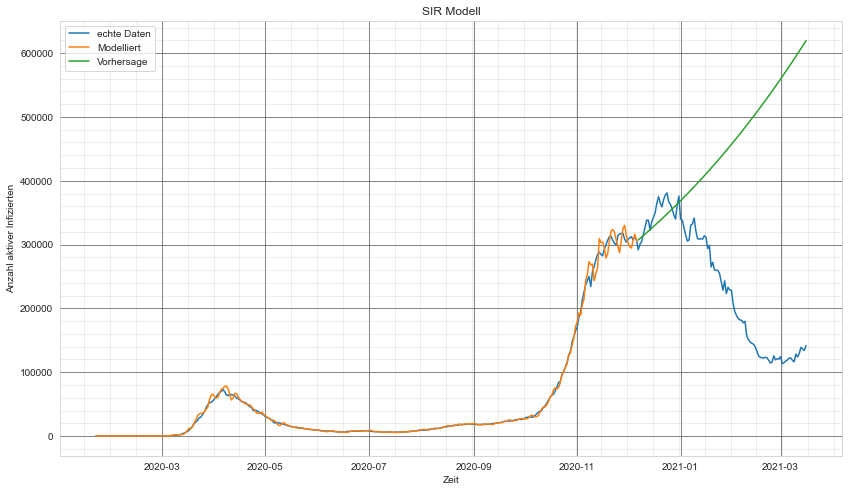

In [195]:
"""
Auswertungen der Vorhersage
Der entsprechende Teil muss auskommentiert werden.
"""
country = 'Germany'
I,R,D,C = load_IR(country,popu_dict[country],0)
beta_list,gamma_list = read_opt(I,country, 5)

"""
3.2.1. Glaetten der Daten (Vorhersage)
smoothdays gibt an wie viel Tage gelaettet werden.
"""
# error1 =[]
# error2=[]
# error3=[]
#smoothdays = [7, 15, 31]
# for t in range(70,400):
#     r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
#     datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
#     for n in smoothdays:
#         I_p = justPredict(5, country, t, r0, dif, datasets_X, I, R,  'smooth15', n)
#         error1.append(abs(I[t + 1] - I_p[t + 1]) / I[t + 1])
#         error2.append(abs(I[t + 2] - I_p[t + 2]) / I[t + 2])
#         error3.append(abs(I[t + 3] - I_p[t + 3]) / I[t + 3])

"""
3.2.2. Verwendung eines Polynom hoeheren Grades
Der Grad des Polynoms wird in der Funktion paramPredict geaendert.

3.2.3. Nutzung eines laengeren Zeitraums fuer die Vorhersage
Der Zeitraum wird bei der Funktion justPredict mit useDays geaendert.
"""
# error11=[]
# error21=[]
# error31=[]
# for t in range(70,400):
#     r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
#     datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
#     I_p = justPredict(5, country, t, r0, dif, datasets_X, I, R,  'normal')
#     error11.append(abs(I[t + 1] - I_p[t + 1]) / I[t + 1])
#     error21.append(abs(I[t + 2] - I_p[t + 2]) / I[t + 2])
#     error31.append(abs(I[t + 3] - I_p[t + 3]) / I[t + 3])

"""
3.2.4. Kombination verschiedener Methoden fuer die Vorhersage
"""
# for t in range(70,400):
#     r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
#     datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
#     I_p = justPredict(5, country, t, r0, dif, datasets_X, I, R,  'mix')
#     error11.append(abs(I[t + 1] - I_p[t + 1]) / I[t + 1])
#     error21.append(abs(I[t + 2] - I_p[t + 2]) / I[t + 2])
#     error31.append(abs(I[t + 3] - I_p[t + 3]) / I[t + 3])

"""Fehler fuer Tabelle 3.11.
Der Zeitraum wird bei der Funktion justPredict mit useDays=37 geaendert."""
# t = 320
# r0,dif = parameterPlot(beta_list[:t],gamma_list[:t])
# datasets_X = np.arange(0, len(r0)).reshape([len(r0),1])
# I_p = justPredict(5, country, t, r0, dif, datasets_X, I, R,  'normal')
# predictPlot(I[:t+100], I_p[:t+100], t)
# print(abs(I[t + 1] - I_p[t + 1]) / I[t + 1])
# print(abs(I[t + 2] - I_p[t + 2]) / I[t + 2])
# print(abs(I[t + 3] - I_p[t + 3]) / I[t + 3])
# print(abs(I[t + 4] - I_p[t + 4]) / I[t + 4])
# print(abs(I[t + 5] - I_p[t + 5]) / I[t + 5])
# print(abs(I[t + 6] - I_p[t + 6]) / I[t + 6])
# print(abs(I[t + 7] - I_p[t + 7]) / I[t + 7])
# print(abs(I[t + 8] - I_p[t + 8]) / I[t + 8])
# print(abs(I[t + 9] - I_p[t + 9]) / I[t + 9])
# print(abs(I[t + 10] - I_p[t + 10]) / I[t + 10])
# print(abs(I[t + 11] - I_p[t + 11]) / I[t + 11])
# print(abs(I[t + 12] - I_p[t + 12]) / I[t + 12])
# print(abs(I[t + 13] - I_p[t + 13]) / I[t + 13])
# print(abs(I[t + 14] - I_p[t + 14]) / I[t + 14])

#I_p = predictTime(country, 5, t)
